# HRS Spectrometer Neutrol network Model

In [1]:
import  pandas as pd
import numpy as np
import sklearn
import math
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import *
import math

## Load the Training dataset
- Merge Multi dataset
- randomize the order of the dataset
- [ftp data server](http://localhost/Data/spectro_nn/)

In [2]:
files = ["../dataGenerator/result/PRex_DataSet_2239.csv",
         "../dataGenerator/result/PRex_DataSet_2240.csv",
         "../dataGenerator/result/PRex_DataSet_2241.csv",
         "../dataGenerator/result/PRex_DataSet_2244.csv",
         "../dataGenerator/result/PRex_DataSet_2245.csv",
         "../dataGenerator/result/PRex_DataSet_2256.csv",
         "../dataGenerator/result/PRex_DataSet_2257.csv"
         ]

# large data set with all the features 
# files = ["../dataGenerator/result/PRex_DataSet_Full_2239.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2240.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2241.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2244.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2245.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2256.csv",
#          "../dataGenerator/result/PRex_DataSet_Full_2257.csv"
#          ]
li = []
for filename in files:
    print("Loading file {}".format(filename))
    df = pd.read_csv(filename)
    li.append(df)
data = pd.concat(li)
data.sample(frac=1) # sample the data with fraction 1. rearrange the data in random order
data.head()

Loading file ../dataGenerator/result/PRex_DataSet_2239.csv
Loading file ../dataGenerator/result/PRex_DataSet_2240.csv
Loading file ../dataGenerator/result/PRex_DataSet_2241.csv
Loading file ../dataGenerator/result/PRex_DataSet_2244.csv
Loading file ../dataGenerator/result/PRex_DataSet_2245.csv
Loading file ../dataGenerator/result/PRex_DataSet_2256.csv
Loading file ../dataGenerator/result/PRex_DataSet_2257.csv


,evtID,CutID,SieveRowID,SieveColID,bpmX,bpmY,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh
0,2239,136,3,5,0.003794,-0.000501,-0.014535,0.011066,0.000552,-0.001618,-0.000817,-0.010117
1,2239,130,4,4,0.003794,-0.000501,-0.027425,0.008514,-0.006709,-0.009000,0.019571,-0.012569
2,2239,179,4,11,0.003794,-0.000501,-0.013932,-0.014659,-0.006437,0.014969,0.012775,0.014835
3,2239,142,2,6,0.003794,-0.000501,-0.010740,0.003021,0.005594,0.001385,-0.014409,-0.003863
4,2239,127,1,4,0.003794,-0.000501,-0.002179,0.012108,0.006449,-0.004135,-0.021206,-0.012569


In [3]:
#print(data[data.evtID.eq(2240)])

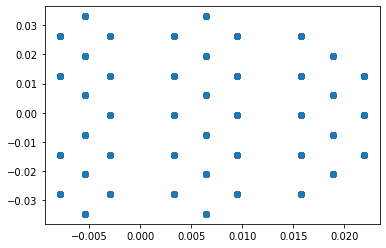

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
x = data[data.evtID.eq(2241)]["targCalPh"]
y = data[data.evtID.eq(2241)]["targCalTh"]
plt.scatter(x,y)
plt.show()

# New Function Used for Train the X, and Y model seperately

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptNet(nn.Module):
    def __init__(self):
        super(OptNet,self).__init__()
        #TODO model, need to auto adapt to the training dataset
        self.fc1 = nn.Linear(4, 16)  # 6*6 from image dimension
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.output(x)
        return x

## Prepare the Data

In [6]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape


(221493, 12)

## Training on the $\theta_{targ}$
### 1. prepare the training data

In [7]:
train_X, test_X, train_y, test_y = train_test_split(
    data.drop(labels=['evtID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data[['targCalTh','targCalPh']],
    test_size=0.2,
    random_state=0)

train_X.shape,train_y.shape,test_X.shape,test_y.shape

((177194, 4), (177194, 2), (44299, 4), (44299, 2))

### 2. train the $\theta_{targ}$ model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_trainTh = torch.tensor(train_X.to_numpy()).float()
y_trainTh = torch.tensor(train_y['targCalTh'].to_numpy()).float()
X_testTh  = torch.tensor(test_X.to_numpy()).float()
y_testTh  = torch.tensor(test_y['targCalTh'].to_numpy()).float()

In [ ]:
thetaOptnet = OptNet()
thetaOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(thetaOptnet.parameters(), lr=0.01)

for epoch in range(1):
    running_loss = 0.0
    for i in range(len(y_trainTh)):
        inputs = X_trainTh[i].to(device)
        labels = y_trainTh[i].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = thetaOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finish Training Theta Parameters")
# save the training model
theta_model_PATH = './model/Theta_net.pth'
torch.save(thetaOptnet.state_dict(), theta_model_PATH)

/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/training_nn/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  2000] loss: 0.001007304
[1,  4000] loss: 0.000423222
[1,  6000] loss: 0.000041730
[1,  8000] loss: 0.000047460
[1, 10000] loss: 0.000042751
[1, 12000] loss: 0.000041424
[1, 14000] loss: 0.000043496
[1, 16000] loss: 0.000039295
[1, 18000] loss: 0.000038548
[1, 20000] loss: 0.000030979
[1, 22000] loss: 0.000031146
[1, 24000] loss: 0.000023805
[1, 26000] loss: 0.000024139
[1, 28000] loss: 0.000023211
[1, 30000] loss: 0.000021039
[1, 32000] loss: 0.000022277
[1, 34000] loss: 0.000023241
[1, 36000] loss: 0.000018491
[1, 38000] loss: 0.000018976
[1, 40000] loss: 0.000020315
[1, 42000] loss: 0.000019514
[1, 44000] loss: 0.000018603
[1, 46000] loss: 0.000018564
[1, 48000] loss: 0.000020371
[1, 50000] loss: 0.000017084
[1, 52000] loss: 0.000019521
[1, 54000] loss: 0.000016991
[1, 56000] loss: 0.000019762
[1, 58000] loss: 0.000017928
[1, 60000] loss: 0.000016807
[1, 62000] loss: 0.000017708
[1, 64000] loss: 0.000018050
[1, 66000] loss: 0.000017458
[1, 68000] loss: 0.000018216
[1, 70000] los

## Training on the $\phi_{targ}$

### 2. train the $\phi_{targ}$ model

In [ ]:
X_trainPh = torch.tensor(train_X.to_numpy()).float()
y_trainPh = torch.tensor(train_y['targCalPh'].to_numpy()).float()
X_testPh  = torch.tensor(test_X.to_numpy()).float()
y_testPh  = torch.tensor(test_y['targCalPh'].to_numpy()).float()

In [ ]:
phiOptnet = OptNet()
phiOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(phiOptnet.parameters(), lr=0.01)

for epoch in range(1):
    running_loss = 0.0
    for i in range(len(y_trainPh)):
        inputs = X_trainPh[i].to(device)
        labels = y_trainPh[i].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs =  phiOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finish Training Theta Parameters")
# save the training model
phi_model_PATH = './model/Phi_net.pth'
torch.save(phiOptnet.state_dict(), phi_model_PATH)


## Test the Training model

### 1. Seperate Test on the $\theta$ and $\phi$ on the test dataset

In [ ]:
testNet_theta = OptNet()
testNet_theta.load_state_dict(torch.load(theta_model_PATH))

test_loss = 0
mseArr = []

with torch.no_grad():
    for i in range(len(y_testTh)):
        positions = X_testTh[i]
        labels = y_testTh[i]

        outputs = testNet_theta(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

In [ ]:
testNet_phi = OptNet()
testNet_phi.load_state_dict(torch.load(phi_model_PATH))

test_loss = 0
mseArr = []
with torch.no_grad():
    for i in range(len(y_testPh)):
        positions = X_testPh[i]
        labels = y_testPh[i]
        outputs = testNet_phi(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))

### Seprate the training and test dataset
- randomly sperate the dataset into training and test dataset with fixed ratio
- auto read the number of features in the dataset, this will be used in the model build

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['evtID','SieveRowID','SieveColID', 'CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data['targCalTh'],
    test_size=0.2,
    random_state=0)
train_feature_count = X_train.shape[1]
print(" Number of features in the training : {}  / overall order {}".format(train_feature_count,math.sqrt(math.sqrt(train_feature_count))-1))
X_train.shape,y_train.shape

## Neural Network Training Model
- need to preload the data
- get the number of features

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptNet(nn.Module):
    def __init__(self):
        super(OptNet,self).__init__()
        #TODO model, need to auto adapt to the training dataset
        self.fc1 = nn.Linear(train_feature_count, 4*train_feature_count)  # 6*6 from image dimension
        self.fc2 = nn.Linear(4*train_feature_count, 4*train_feature_count)
        self.fc3 = nn.Linear(4*train_feature_count, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.output(x)
        return x

## Training the model
- load the data to the torch tensor
- load the GPU Calculation

## 1. Seperate the data for TargX and TargY and train the seperate model

In [ ]:
X_train = torch.tensor(X_train.to_numpy()).float()
y_train = torch.tensor(y_train.to_numpy()).float()
X_test  = torch.tensor( X_test.to_numpy()).float()
y_test  = torch.tensor( y_test.to_numpy()).float()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = OptNet()
net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# training
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(len(y_train)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = X_train[i].to(device)
        labels = y_train[i].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0



In [ ]:
print('Finished Training')
model_PATH = './model/net.pth'
torch.save(net.state_dict(), model_PATH)

net = OptNet()
net.load_state_dict(torch.load(model_PATH))

test_loss = 0
mseArr = []
with torch.no_grad():
    for i in range(len(y_test)):
        positions = X_test[i]
        labels = y_test[i]
        outputs = net(positions)
        loss = criterion(outputs,labels)
        test_loss += loss
        mseArr.append(loss)
print('test_error is :{}   / {}'.format(test_loss,sum(mseArr)/len(mseArr)))


# 